In [72]:
import jax
import numpy as np
from jax import grad
import jax.numpy as jnp
import numpy as np
import ott
from tqdm import tqdm
import seaborn as sns
#import optax

import matplotlib.pyplot as plt

Implementation for a 1D optimal transport problem.

$n = 500, \; \eta = 1200, \; c = r = \frac{1}{n}\textbf{1}, \; C,D_I,D_E \in \mathbb{R}^{n\times n}$. 

The entries of $C,D_I,D_E \sim \mathcal{U}([0,1])$. 

Two threshold variables $t_I,t_E$. We set them as $t_I = t_E = \frac{1}{2}$

We consider the following optimization problem : 

$$ \min_{P : P\textbf{1}=r, P^T\textbf{1}=c} \quad \quad C \cdot P $$
$$\text{subject to : } D_I\cdot P \leq t_I, \; D_E \cdot P = t_E$$ 

In order to be able to use the general form we can use :

$$D1 = (D_I - t_I \textbf{1}_{n\times n})/n \quad \text{and} \quad D_2 = (D_E - t_E \textbf{1}_{n\times n})/n$$

## Setup for uniform source and target with random constraints

In [90]:
n = 500
eta = 1.
epsilon = 1e-3
N = 40 #number of iterations of the algorithm, under 100 is sufficient according to the paper
one = jnp.ones((n,1))
key1, key2, key3 = jax.random.split(jax.random.key(0), 3)
c = jnp.ones((n,1))*1.5 + jax.random.normal(key=key1, shape=(n,1))*0.6#source
r = jnp.ones((n,1))*0.2 + jax.random.normal(key=key2, shape=(n,1))*0.5 #target
K = 1 #number of inequality constraints
L = 1 #number of equality constraints
key1, key2, key3 = jax.random.split(jax.random.key(0), 3)
C = np.random.uniform(low=0., high=1, size=(n,n))
#C = jax.random.uniform(key=key1, minval=0., maxval=1., shape=(n, n))
for i in range(n):
    for j in range(i,n):
        C[i,j] *= 1.5
        if C[i,j] >= 1:
            C[i,j] = 1
for i in range(n):
    for j in range(0,i):
        C[i,j] *= 0.5
C = jnp.array(C)
DI = jax.random.uniform(key=key2, minval=0., maxval=1., shape=(n, n))
DE = jax.random.uniform(key=key3, minval=0., maxval=1., shape=(n, n))
tI = 1/2
tE = 1/2
D1 = (DI - tI*one@one.T)/n
D2 = (DE - tE*one@one.T)/n

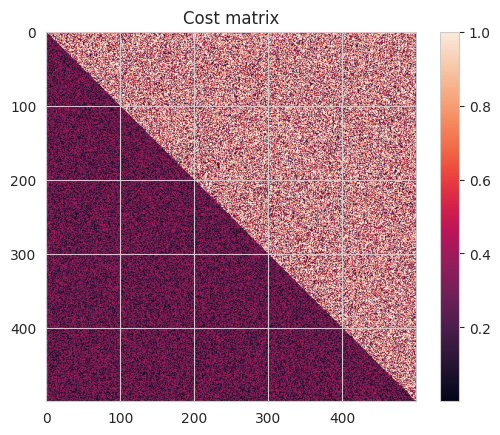

In [91]:
plt.title('Cost matrix')
plt.imshow(C)
plt.colorbar()

<Axes: ylabel='Density'>

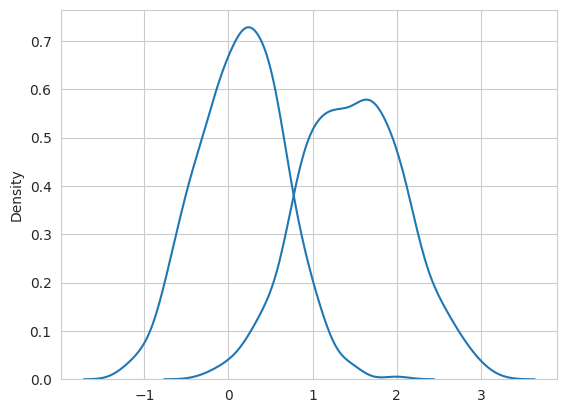

In [92]:
sns.set_style('whitegrid')

sns.kdeplot(np.array(c),color='r',legend=False)
sns.kdeplot(np.array(r),color='b',legend=False)

As it is of main importance for the algorithm we recall here the definition of the Lyapounov function $f$ : 

$$f(x,y,a) = \underbrace{-\frac{1}{\eta}\sum_{ij}\exp\left(\eta(-C_{ij} + \sum_{m=1}^{K+L}a_m(D_m)_{i,j} + x_i +y_j) +1  \right)}_{(1)} + \underbrace{\sum_i x_i r_i + \sum_j y_j c_j}_{(2)} - \underbrace{\frac{1}{\eta}\sum_{k=1}^K\exp(-\eta a_k -1)}_{(3)}$$

In [46]:
def f(x,y,a):
    """
    dual potential function

    -------------------------------------------
    parameters:


    x : jnp array, of shape (n,1)
    dual variable

    y : jnp array, of shape (n,1)
    dual variable

    a : jnp array, of shape (K+L,1)
    constraint dual variables (excluding original constraints on rows and columns)

    -----------------------------------------------

    returns:

    output : real number, value of the min of the lagrangian

    """
    #to keep a vectorized procedure for autodiff
    first = jnp.array([1,0])
    first.reshape(2,1)
    second = jnp.array([0,1])
    second.reshape(2,1)
    
    a_0 = first.T@a
    a_1 = second.T@a
    sum_m = a_0*D1 + a_1*D2


    exp_eta_x = jnp.exp(jnp.clip(eta * x, -40.0, 40.0))      
    exp_eta_y = jnp.exp(jnp.clip(eta * y, -40.0, 40.0))      
    exp_core = jnp.exp(jnp.clip(eta * (-C + sum_m) - 1, -40.0, 40.0))

    first_term = - (1 / eta) * (exp_eta_x.T @ exp_core @ exp_eta_y)  

    second_term = x.T @ r + y.T @ c  

    exp_a0 = jnp.exp(jnp.clip(-eta * a_0 - 1, -40.0, 40.0))  
    exp_a1 = jnp.exp(jnp.clip(-eta * a_1 - 1, -40.0, 40.0))  
    third_term = - (1 / eta) * (exp_a0 + exp_a1)  
    output = first_term + second_term + third_term
    return output

In [48]:
#we define these functions in order to facilitate the following optimization steps
def f_wrapped(params, y):
    x, a = jnp.split(params, [n])
    x = x.reshape(-1, 1)
    a = a.reshape(-1, 1)
    return f(x, y, a)

def f_at(a_t, x, y):
    a_vec, t_scalar = jnp.split(a_t, [2])
    a_vec = a_vec.reshape(-1, 1)
    t_scalar = t_scalar[0]
    x_shifted = x + t_scalar * jnp.ones_like(x)
    return f(x_shifted, y, a_vec)[0, 0]


grad_f_at = jax.grad(f_at)

"""
@jax.jit
def update(params, opt_state, y_fixed):
    grads = grad_f(params, y_fixed)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state
@jax.jit
def update_a_t(a_t, x, y):
    grads = grad_f_at(a_t)
    return a_t - lr * grads
"""

'\n@jax.jit\ndef update(params, opt_state, y_fixed):\n    grads = grad_f(params, y_fixed)\n    updates, opt_state = optimizer.update(grads, opt_state)\n    new_params = optax.apply_updates(params, updates)\n    return new_params, opt_state\n@jax.jit\ndef update_a_t(a_t, x, y):\n    grads = grad_f_at(a_t)\n    return a_t - lr * grads\n'

# Main algorithm

In [70]:
#initialization : 

i = 0
x = jnp.ones((n,1))*1e-4
y = jnp.ones((n,1))*1e-4
key_a = jax.random.PRNGKey(0)
a = 1e-3 * jax.random.normal(key_a, (2, 1))
t = jnp.array(1e-3)
lr = 1e-3 #learning rate for the optimization steps



#iterations
for _ in tqdm(range(N)):

    #row and columns scaling
    first = jnp.array([1, 0]).reshape(2, 1)
    second = jnp.array([0, 1]).reshape(2, 1)
    
    a_0 = first.T@a
    a_1 = second.T@a
    sum_m = a_0*D1 + a_1*D2
    x += (jnp.log(jnp.clip(r, a_min=1e-8))-jnp.log(jnp.clip(P @ one, a_min=1e-8)))/eta
    exp_input = jnp.clip(eta*(-C+sum_m+x@one.T+y@one.T)-1, -40.0, 40.0)
    P = jnp.exp(exp_input)
    P = jnp.clip(P, a_min=1e-8)
    y += (jnp.log(jnp.clip(c, a_min=1e-8))-jnp.log(jnp.clip(P@one, a_min=1e-8)))/eta
    

    #now is the optimization step that is costly
    params0 = jnp.concatenate([x.flatten(), a.flatten()])
    y_fixed = y.copy()
    
    a_t = jnp.concatenate([a.flatten(), jnp.array([t])])

    
    for _ in range(100):
        grads = grad_f_at(a_t, x, y)
        grads = jnp.clip(grads, -10.0, 10.0)
        a_t = a_t - lr * grads
    a, t = jnp.split(a_t, [2])
    a = a.reshape(-1, 1)
    t = t[0]
    """
    print('a : ', a, '\n',
         'x : ', x[:3,0], '\n',
          'y : ', y[:3,0], '\n',
         'P : ', P[:3,:3], '\n',
         'grads : ', grads)
    """

100%|██████████| 40/40 [03:16<00:00,  4.90s/it]


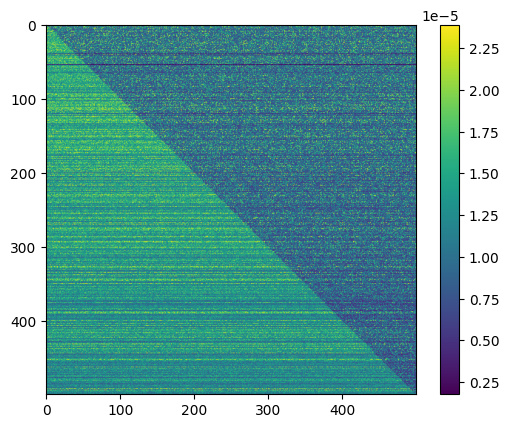

In [71]:
plt.imshow(P)
plt.colorbar()